In [4]:
pip install ultralytics opencv-python albumentations tqdm torch torchvision scikit-learn Pillow pandas matplotlib seaborn


  Using cached ultralytics-8.2.59-py3-none-any.whl.metadata (41 kB)
  Using cached albumentations-1.4.11-py3-none-any.whl.metadata (39 kB)
  Using cached ultralytics_thop-2.0.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl.metadata (12 kB)
  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Using cached albucore-0.0.12-py3-none-any.whl.metadata (3.1 kB)
  Using cached eval_type_backport-0.2.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
Using cached ultralytics-8.2.59-py3-none-any.whl (802 kB)
Using cached albumentations-1.4.11-py3-none-any.whl (165 kB)
Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl (11.0 MB)
Using cached albucore-0.0.12-py3-none-any.whl (8.4 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Using cached pydantic-

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-cloud-auth 0.1.4 requires pydantic<2.0, but you have pydantic 2.8.2 which is incompatible.


In [2]:
pip install --upgrade seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ------------------------------ --------- 225.3/294.9 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install torch torchvision

In [4]:
import torch

def check_cuda_availability():
    if torch.cuda.is_available():
        print("CUDA is available.")
        print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Device Count: {torch.cuda.device_count()}")
    else:
        print("CUDA is not available.")

# Call the function
check_cuda_availability()

CUDA is available.
CUDA Device Name: NVIDIA GeForce GTX 1080
CUDA Device Count: 1


In [5]:
import os
os.environ['WANDB_DISABLED'] = 'true'
from ultralytics import YOLO
import cv2
import albumentations as A
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from pathlib import Path
import torchvision.models as models
import random
from collections import Counter
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

E:\CodingRelated\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [12]:
# # 500 Samples. Split is 7(1/2 White BG - 1/2 Environment BG)/2/1

# def split_dataset(root_dir, output_dir, train_count=350, val_count=100, test_count=50):
#     total_count = train_count + val_count + test_count
#     train_white_bg_count = train_count // 2
#     train_env_bg_count = train_count - train_white_bg_count

#     train_dir = os.path.join(output_dir, 'train')
#     val_dir = os.path.join(output_dir, 'val')
#     test_dir = os.path.join(output_dir, 'test')

#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(val_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)

#     class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

#     for class_dir in class_dirs:
#         class_path = os.path.join(root_dir, class_dir)
        
#         # Process White BG images for the training set
#         white_bg_path = os.path.join(class_path, 'White BG')
#         white_bg_images = []
#         if os.path.exists(white_bg_path):
#             white_bg_images = [f for f in os.listdir(white_bg_path) if os.path.isfile(os.path.join(white_bg_path, f)) and 'Discard' not in os.path.join(white_bg_path, f)]
#             random.shuffle(white_bg_images)
#             white_bg_images = white_bg_images[:train_white_bg_count]

#         os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
#         for img in white_bg_images:
#             shutil.copy(os.path.join(white_bg_path, img), os.path.join(train_dir, class_dir, f"white_bg_{img}"))

#         # Process Environmental images
#         env_path = os.path.join(class_path, 'All')
#         env_images = [f for f in os.listdir(env_path) if os.path.isfile(os.path.join(env_path, f))]
#         random.shuffle(env_images)

#         # Ensure we have enough images
#         if len(env_images) < (train_env_bg_count + val_count + test_count):
#             print(f"Warning: Not enough images for {class_dir}. Only {len(env_images)} available.")
#             continue

#         test_images = env_images[:test_count]
#         val_images = env_images[test_count:test_count + val_count]
#         train_images = env_images[test_count + val_count:test_count + val_count + train_env_bg_count]

#         os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
#         for img in test_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(test_dir, class_dir, f"env_{img}"))

#         os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
#         for img in val_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(val_dir, class_dir, f"env_{img}"))

#         os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
#         for img in train_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(train_dir, class_dir, f"env_{img}"))

#     print("Dataset split completed.")
#     return train_dir, val_dir, test_dir, class_dirs


In [20]:
# # 500 Samples. Split is 7(1/3 White BG - 2/3 Environment BG)/2(1/3 White BG - 2/3 Environment BG)/1

# def split_dataset(root_dir, output_dir, train_count=350, val_count=100, test_count=50):
#     total_count = train_count + val_count + test_count
#     train_white_bg_count = train_count // 3
#     train_env_bg_count = train_count - train_white_bg_count
#     val_white_bg_count = val_count // 3
#     val_env_bg_count = val_count - val_white_bg_count

#     train_dir = os.path.join(output_dir, 'train')
#     val_dir = os.path.join(output_dir, 'val')
#     test_dir = os.path.join(output_dir, 'test')

#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(val_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)

#     class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

#     for class_dir in class_dirs:
#         class_path = os.path.join(root_dir, class_dir)
        
#         # Process White BG images for the training and validation sets
#         white_bg_path = os.path.join(class_path, 'White BG')
#         white_bg_images = []
#         if os.path.exists(white_bg_path):
#             white_bg_images = [f for f in os.listdir(white_bg_path) if os.path.isfile(os.path.join(white_bg_path, f)) and 'Discard' not in os.path.join(white_bg_path, f)]
#             random.shuffle(white_bg_images)
#             white_bg_train_images = white_bg_images[:train_white_bg_count]
#             white_bg_val_images = white_bg_images[train_white_bg_count:train_white_bg_count + val_white_bg_count]

#         os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
#         for img in white_bg_train_images:
#             shutil.copy(os.path.join(white_bg_path, img), os.path.join(train_dir, class_dir, f"white_bg_{img}"))

#         os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
#         for img in white_bg_val_images:
#             shutil.copy(os.path.join(white_bg_path, img), os.path.join(val_dir, class_dir, f"white_bg_{img}"))

#         # Process Environmental images
#         env_path = os.path.join(class_path, 'All')
#         env_images = [f for f in os.listdir(env_path) if os.path.isfile(os.path.join(env_path, f))]
#         random.shuffle(env_images)

#         # Ensure we have enough images
#         if len(env_images) < (train_env_bg_count + val_env_bg_count + test_count):
#             print(f"Warning: Not enough images for {class_dir}. Only {len(env_images)} available.")
#             continue

#         test_images = env_images[:test_count]
#         val_images = env_images[test_count:test_count + val_env_bg_count]
#         train_images = env_images[test_count + val_env_bg_count:test_count + val_env_bg_count + train_env_bg_count]

#         os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
#         for img in test_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(test_dir, class_dir, f"env_{img}"))

#         os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
#         for img in val_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(val_dir, class_dir, f"env_{img}"))

#         os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
#         for img in train_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(train_dir, class_dir, f"env_{img}"))

#     print("Dataset split completed.")
#     return train_dir, val_dir, test_dir, class_dirs


In [6]:
def split_dataset(root_dir, output_dir, val_count=80, test_count=40):
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(root_dir, class_dir)

        # Process Environmental images
        env_path = os.path.join(class_path, 'All')
        env_images = [f for f in os.listdir(env_path) if os.path.isfile(os.path.join(env_path, f))]
        random.shuffle(env_images)

        # Ensure we have enough images for validation and test
        if len(env_images) < val_count + test_count:
            print(f"Warning: Not enough images for {class_dir}. Only {len(env_images)} available.")
            continue

        test_images = env_images[:test_count]
        val_images = env_images[test_count:test_count + val_count]
        train_images = env_images[test_count + val_count:]

        os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
        for img in test_images:
            shutil.copy(os.path.join(env_path, img), os.path.join(test_dir, class_dir, f"env_{img}"))

        os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
        for img in val_images:
            shutil.copy(os.path.join(env_path, img), os.path.join(val_dir, class_dir, f"env_{img}"))

        os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
        for img in train_images:
            shutil.copy(os.path.join(env_path, img), os.path.join(train_dir, class_dir, f"env_{img}"))

    print("Dataset split completed.")
    return train_dir, val_dir, test_dir, class_dirs

In [7]:
root_dir = r"G:\SNAPFOLIA OJT SY 24 25\Dataset Versions\DATASET_3.2"
output_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_All_Env"

In [8]:
# Define the directories where your split data is stored
train_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train"
val_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val"
test_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\test"

# Get the class directories from the train directory
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

In [6]:
train_dir, val_dir, test_dir, class_dirs = split_dataset(root_dir, output_dir)

Dataset split completed.


In [9]:
# Initialize counters
train_counts = Counter()
val_counts = Counter()
test_counts = Counter()

# Calculate counts
for class_dir in class_dirs:
    train_counts[class_dir] = len(os.listdir(os.path.join(train_dir, class_dir)))
    val_counts[class_dir] = len(os.listdir(os.path.join(val_dir, class_dir)))
    test_counts[class_dir] = len(os.listdir(os.path.join(test_dir, class_dir)))

# Save class names in a variable
classes = [class_name for class_name in class_dirs]

# Print the counts
print("\nDataset Labels:")
print({class_name: idx for idx, class_name in enumerate(class_dirs)})

print("\nTotal Images per Class:")
for idx, class_name in enumerate(class_dirs):
    total = train_counts[class_name] + val_counts[class_name] + test_counts[class_name]
    print(f"{idx}    {class_name}: {total}")

print("\nImages per Class in TRAIN:")
for idx, (class_name, count) in enumerate(train_counts.items()):
    print(f"{idx}    {class_name}: {count}")

print("\nImages per Class in VALIDATION:")
for idx, (class_name, count) in enumerate(val_counts.items()):
    print(f"{idx}    {class_name}: {count}")

print("\nImages per Class in TEST:")
for idx, (class_name, count) in enumerate(test_counts.items()):
    print(f"{idx}    {class_name}: {count}")


Dataset Labels:
{'Acacia': 0, 'Alibangbang': 1, 'Amugis': 2, 'Apitong': 3, 'Asis': 4, 'Balayong': 5, 'Balete': 6, 'Banaba': 7, 'Bani': 8, 'Barako': 9, 'Bayabas': 10, 'Betis': 11, 'Binunga': 12, 'Dao': 13, 'Dita': 14, 'Duhat': 15, 'Eucalyptus': 16, 'Guyabano': 17, 'Hinadyong': 18, 'Ilang Ilang': 19, 'Ipil': 20, 'Kalios': 21, 'Kamagong': 22, 'Langka': 23, 'Lansones': 24, 'Madre Cacao': 25, 'Mahogany': 26, 'Mangga': 27, 'Mulawin': 28, 'Narra': 29, 'Native Talisay': 30, 'Palo Maria': 31, 'Scramble Egg': 32, 'Sintores': 33, 'Tibig': 34, 'Yakal': 35}

Total Images per Class:
0    Acacia: 417
1    Alibangbang: 448
2    Amugis: 574
3    Apitong: 475
4    Asis: 488
5    Balayong: 475
6    Balete: 459
7    Banaba: 457
8    Bani: 400
9    Barako: 477
10    Bayabas: 425
11    Betis: 393
12    Binunga: 425
13    Dao: 407
14    Dita: 420
15    Duhat: 535
16    Eucalyptus: 461
17    Guyabano: 524
18    Hinadyong: 360
19    Ilang Ilang: 456
20    Ipil: 403
21    Kalios: 429
22    Kamagong: 525
23    

In [10]:
def get_classes_from_directory(directory):
    return sorted([d.name for d in os.scandir(directory) if d.is_dir()])

def print_number_of_classes(directory):
    classes = get_classes_from_directory(directory)
    print(f"Number of classes: {len(classes)}")
    print(f"Classes: {classes}")
    
# Print the number of classes
print_number_of_classes(train_dir)

Number of classes: 36
Classes: ['Acacia', 'Alibangbang', 'Amugis', 'Apitong', 'Asis', 'Balayong', 'Balete', 'Banaba', 'Bani', 'Barako', 'Bayabas', 'Betis', 'Binunga', 'Dao', 'Dita', 'Duhat', 'Eucalyptus', 'Guyabano', 'Hinadyong', 'Ilang Ilang', 'Ipil', 'Kalios', 'Kamagong', 'Langka', 'Lansones', 'Madre Cacao', 'Mahogany', 'Mangga', 'Mulawin', 'Narra', 'Native Talisay', 'Palo Maria', 'Scramble Egg', 'Sintores', 'Tibig', 'Yakal']


In [11]:
model_path = 'yolov8n-cls.pt'

def load_model_on_cuda(model_path):
    # Load the model
    model = YOLO(model_path)
    
    # Check if CUDA is available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        model.to(device)
        print(f"Model moved to {device}")
    else:
        device = torch.device('cpu')
        print(f"CUDA not available, using {device}")

    return model

model = load_model_on_cuda(model_path)

Model moved to cuda


In [11]:
model.train(data='C:\Snapfolia (C Drive Access)\Output_3.2_All_Env', epochs=20, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.60 available  Update with 'pip install -U ultralytics'
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=C:\Snapfolia (C Drive Access)\Output_3.2_All_Env, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fa

train: Scanning C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train... 12288 images, 1 corrupt: 100%|██████████| 122

train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train\Acacia\env_Acacia D (10).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train\Acacia\env_Acacia D (13).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train\Acacia\env_Acacia D (2).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train\Acacia\env_Acacia D (21).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train\Acacia\env_Acacia D (25).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train\Acacia\env_Acacia D (28).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train\Acacia\env_Acacia D (3).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train\

train: New cache created: C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train.cache


val: Scanning C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val... 2880 images, 0 corrupt: 100%|██████████| 2880/288


val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val\Acacia\env_Acacia D (1).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val\Acacia\env_Acacia D (22).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val\Acacia\env_Acacia D (55).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val\Acacia\env_Acacia D (58).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val\Acacia\env_Acacia D (61).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val\Acacia\env_Acacia Q (10).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val\Acacia\env_Acacia Q (12).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val\Acacia\env_Acacia Q (13).jpg: c

               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:34<00:00,  1.05s/it]

                   all      0.919      0.993



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:31<00:00,  1.02s/it]

                   all      0.932      0.995



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:29<00:00,  1.01it/s]

                   all      0.971      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:32<00:00,  1.02s/it]

                   all      0.978      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:32<00:00,  1.03s/it]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:29<00:00,  1.00it/s]

                   all      0.981      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:30<00:00,  1.00s/it]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:30<00:00,  1.01s/it]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:28<00:00,  1.02it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20      1.65G    0.07137         16        640: 100%|██████████| 768/768 [07:29<00:00,  1.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:31<00:00,  1.01s/it]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20      1.65G    0.06146         16        640: 100%|██████████| 768/768 [07:15<00:00,  1.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:26<00:00,  1.04it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20      1.65G    0.06126         16        640: 100%|██████████| 768/768 [07:14<00:00,  1.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:28<00:00,  1.02it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20      1.65G    0.05322         16        640: 100%|██████████| 768/768 [07:17<00:00,  1.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:30<00:00,  1.01s/it]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20      1.65G    0.05166         16        640: 100%|██████████| 768/768 [07:19<00:00,  1.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:30<00:00,  1.00s/it]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20      1.65G    0.04462         16        640: 100%|██████████| 768/768 [07:22<00:00,  1.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:27<00:00,  1.03it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20      1.65G    0.03987         16        640: 100%|██████████| 768/768 [07:33<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:30<00:00,  1.00s/it]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20      1.65G    0.03572         16        640: 100%|██████████| 768/768 [07:38<00:00,  1.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:32<00:00,  1.03s/it]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20      1.65G    0.03455         16        640: 100%|██████████| 768/768 [07:33<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:33<00:00,  1.04s/it]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20      1.65G    0.03046         16        640: 100%|██████████| 768/768 [07:24<00:00,  1.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:33<00:00,  1.04s/it]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20      1.65G    0.02744         16        640: 100%|██████████| 768/768 [07:22<00:00,  1.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:28<00:00,  1.02it/s]

                   all      0.993          1



20 epochs completed in 3.016 hours.
Optimizer stripped from runs\classify\train4\weights\last.pt, 3.1MB
Optimizer stripped from runs\classify\train4\weights\best.pt, 3.1MB

Validating runs\classify\train4\weights\best.pt...
Ultralytics YOLOv8.2.59  Python-3.11.7 torch-2.3.1 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,480,996 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\train... found 12289 images in 36 classes  
val: C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\val... found 2880 images in 36 classes  
test: C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\test... found 1440 images in 36 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [01:33<00:00,  1.04s/it]


                   all      0.994          1
Speed: 0.4ms preprocess, 1.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train4
Results saved to runs\classify\train4


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001AD56BD2AD0>
curves: []
curves_results: []
fitness: 0.9970486164093018
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9944444298744202, 'metrics/accuracy_top5': 0.9996528029441833, 'fitness': 0.9970486164093018}
save_dir: WindowsPath('runs/classify/train4')
speed: {'preprocess': 0.4488560888502333, 'inference': 1.1818458636601765, 'loss': 0.0006948908170064291, 'postprocess': 0.0}
task: 'classify'
top1: 0.9944444298744202
top5: 0.9996528029441833

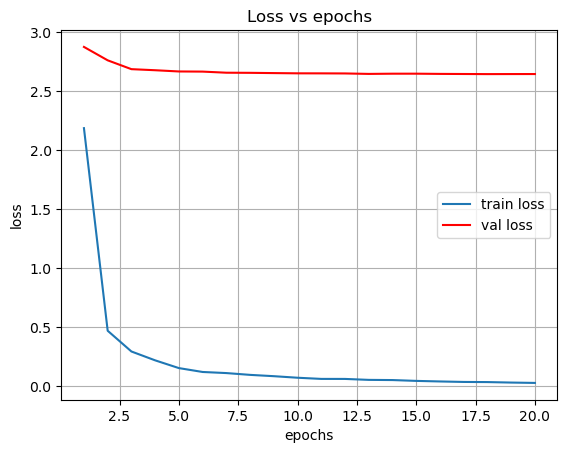

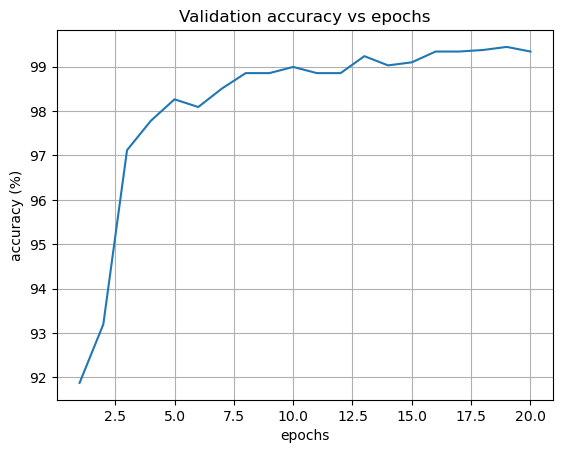

In [12]:
results_path = './runs/classify/train4/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [13]:
def generate_classification_report(run_dir, data_dir, classes):
    # Load the model
    model = YOLO(f'{run_dir}/weights/best.pt')
    
    # Prepare the test dataset
    test_dir = os.path.join(data_dir, 'test')
    test_images = []
    test_labels = []
    for class_id, class_name in enumerate(classes):
        class_dir = os.path.join(test_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            test_images.append(image_path)
            test_labels.append(class_id)
    
    # Predict and collect results
    y_true = []
    y_pred = []
    for image_path, label in zip(test_images, test_labels):
        predict = model(image_path)
        probs = predict[0].probs.data.tolist()
        predicted_class = np.argmax(probs)
        
        y_true.append(label)
        y_pred.append(predicted_class)
    
    # Debugging output
    print(f"Unique classes in y_true: {np.unique(y_true)}")
    print(f"Unique classes in y_pred: {np.unique(y_pred)}")
    
    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=classes)
    print(report)

    return y_true, y_pred



image 1/1 C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\test\Acacia\env_Acacia B (3).jpg: 640x640 Acacia 1.00, Scramble Egg 0.00, Tibig 0.00, Amugis 0.00, Binunga 0.00, 3.0ms
Speed: 55.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\test\Acacia\env_Acacia C (9).jpg: 640x640 Acacia 1.00, Scramble Egg 0.00, Tibig 0.00, Betis 0.00, Mulawin 0.00, 3.0ms
Speed: 53.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\test\Acacia\env_Acacia D (24).jpg: 640x640 Acacia 1.00, Scramble Egg 0.00, Duhat 0.00, Tibig 0.00, Banaba 0.00, 3.0ms
Speed: 53.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Snapfolia (C Drive Access)\Output_3.2_All_Env\test\Acacia\env_Acacia D (26).jpg: 640x640 Acacia 1.00, Amugis 0.00, Scramble Egg 0.00, Duhat 0.00, Hinadyong 0.00

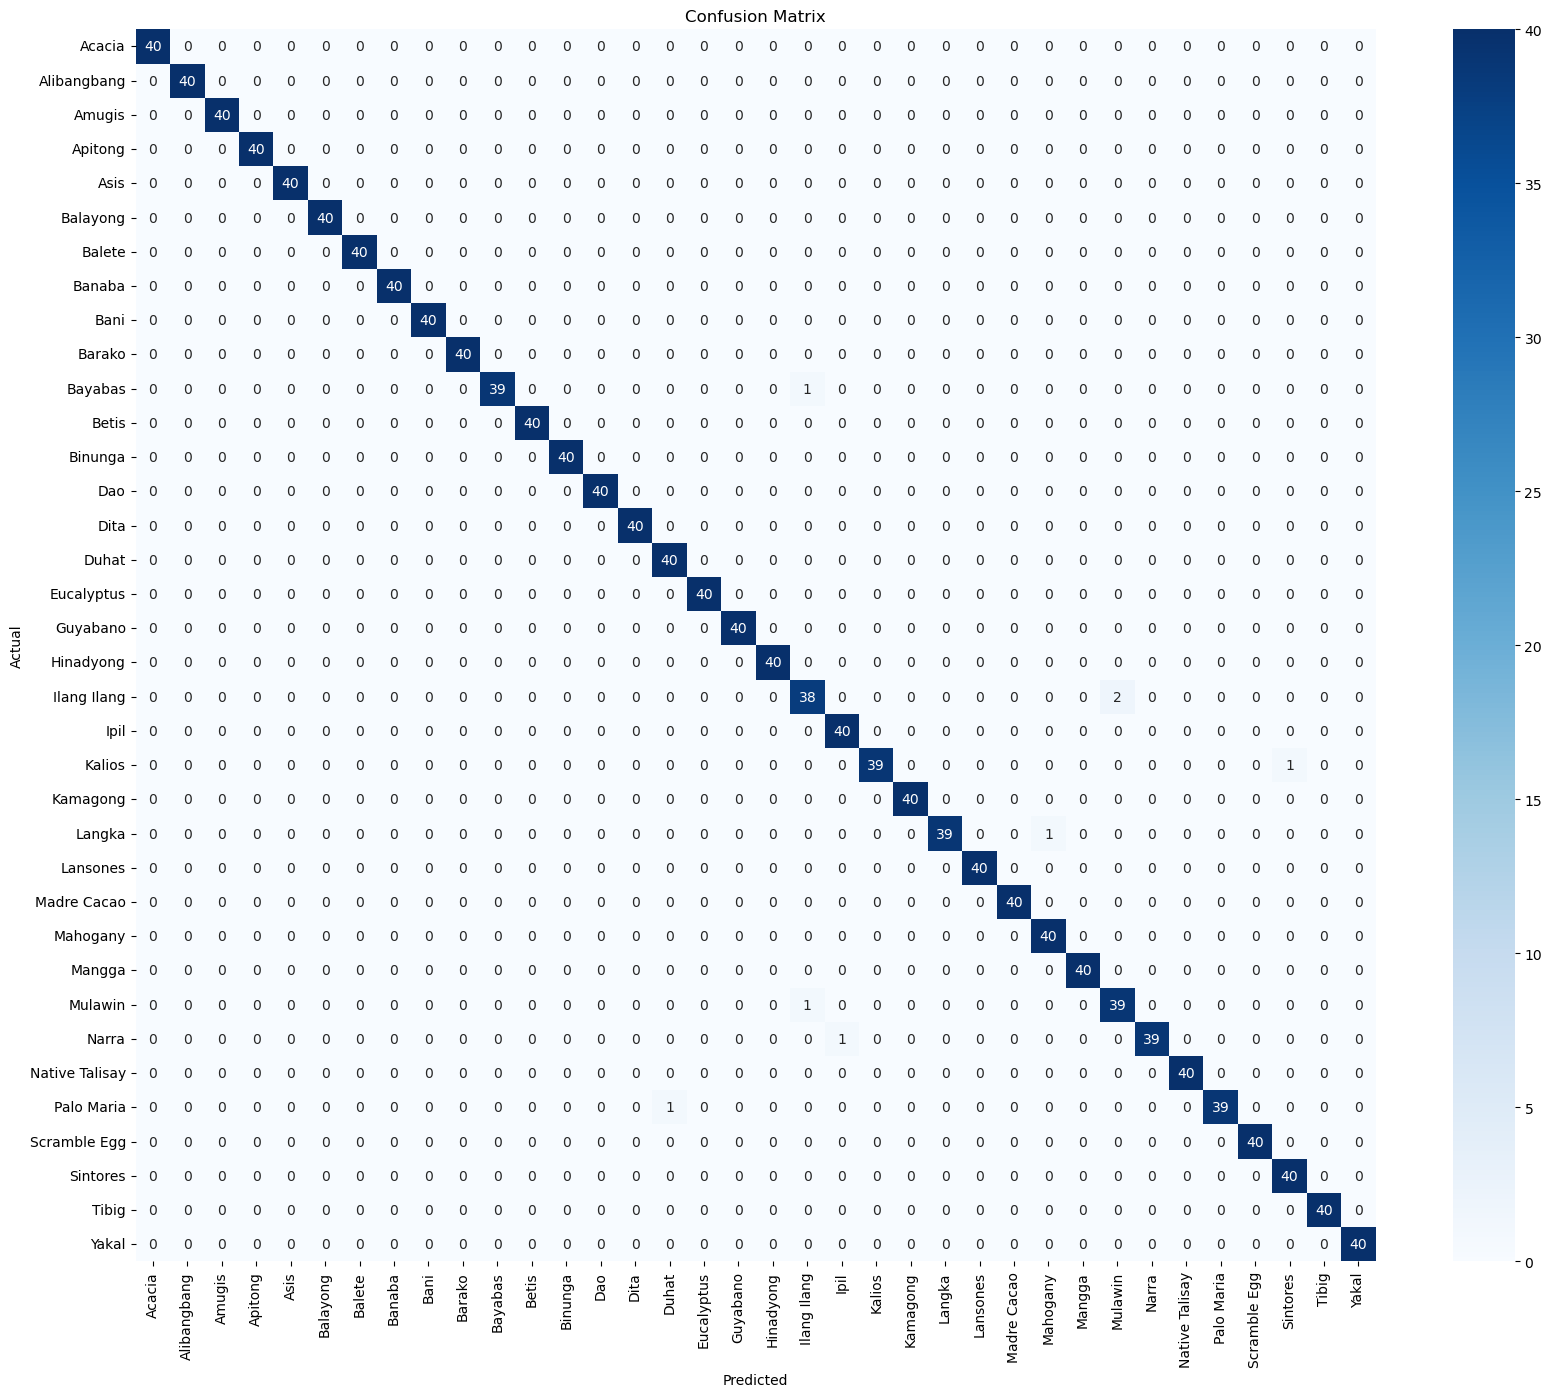

In [16]:
def generate_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
# Generate classification report and confusion matrix
y_true, y_pred = generate_classification_report('runs/classify/train4', r"C:\Snapfolia (C Drive Access)\Output_3.2_All_Env", classes)
generate_confusion_matrix(y_true, y_pred, classes)